In [32]:
import numpy as np
import math
import xarray as xr
import dask
from sklearn.utils import shuffle
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4
import pandas as pd
from sklearn.cluster import KMeans
bm = Basemap() 

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


In [33]:
path = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/Preprocessing_Scripts/Points/Hundred_X/Hundred_X.nc'
real_ds = xr.open_dataset(path)

In [34]:
w_velocity = real_ds['CRM_W_LON_0e_to_360e_LAT_20s_to_20n'].values
w_velocity = np.squeeze(w_velocity)

In [35]:
print(w_velocity.shape)

(1067437, 30, 128)


In [36]:
coordinates = np.loadtxt("/fast/gmooers/VAE_Stuff/Coordinates/Coordinates_List.txt", delimiter=',')
label_values = np.zeros(shape=(len(coordinates)))
for i in range(len(coordinates)):
    lon = coordinates[i][0]
    lat = coordinates[i][1]
    if lon > 180.0:
        lon = lon - 360.0
    if bm.is_land(lon, lat) == True:
        label_values[i] = 1

In [37]:
labels = np.zeros(shape=(len(w_velocity)))
labels[:] = np.nan 

In [38]:
start = 0
end = int(len(w_velocity)/109)
for i in range(len(label_values)):
    if label_values[i] == 0:
        labels[start:end] = 0
        start = start+int(len(w_velocity)/109)
        end = end+int(len(w_velocity)/109)
    if label_values[i] == 1:
        labels[start:end] = 1
        start = start+int(len(w_velocity)/109)
        end = end+int(len(w_velocity)/109)

In [39]:
num_samples = len(w_velocity)
lev = len(w_velocity[0])
crm_x = len(w_velocity[0][0])

In [40]:
np.isnan(w_velocity).any()

False

In [41]:
X_Shuffled, Y_Shuffled = shuffle(w_velocity, labels, random_state=0)

In [43]:
w_train = X_Shuffled[:int(4*len(X_Shuffled)/5),:,:]
w_test = X_Shuffled[int(4*len(X_Shuffled)/5):,:,:]
y_train = Y_Shuffled[:int(4*len(Y_Shuffled)/5)]
y_test =  Y_Shuffled[int(4*len(Y_Shuffled)/5):]

In [44]:
my_max = max(w_train.max(), w_test.max())
my_min = min(w_train.min(), w_test.min())

In [46]:
rescaled_train = np.interp(w_train, (my_min, my_max), (0, +1))
rescaled_test = np.interp(w_test, (my_min, my_max), (0, +1))

In [48]:
Cluster_Test = w_test.reshape((len(w_test),128*30))

In [49]:
N_cluster=3
km = KMeans(n_clusters=N_cluster, init='k-means++')
y_km = km.fit_predict(Cluster_Test)

In [50]:
group = {}
mean = {}
std = {}
for igroup in range(N_cluster):
    group[igroup] = w_test[y_km==igroup,:,:]
    mean[igroup] = np.mean(group[igroup],axis=0)
    std[igroup] = np.std(group[igroup],axis=0)

In [51]:
lengths = []
for igroup in range(N_cluster):
    lengths.append(len(group[igroup]))

In [52]:
print(lengths)

[5597, 5723, 202168]


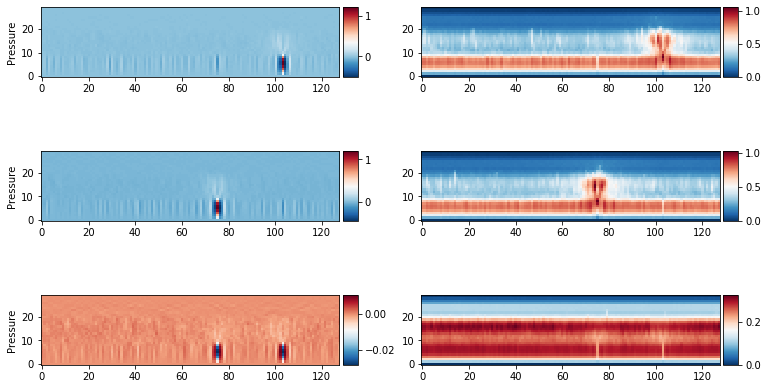

In [58]:
cmap="RdBu_r"
var_labels = ["Group 1", "Group 2", "Group 3"]
fig, ax = plt.subplots(nrows=N_cluster,ncols=2,figsize=(12.5,7.5))
for igroup in range(N_cluster):
    axes = ax[igroup]
    cs = axes[0].imshow(mean[igroup], cmap=cmap)
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)
    cs = axes[1].imshow(std[igroup], cmap=cmap)
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)
    axes[0].set_ylim(axes[0].get_ylim()[::-1])
    axes[1].set_ylim(axes[1].get_ylim()[::-1])
    if igroup == 3:
        axes[0].set_xlabel('CRMs')
        axes[1].set_xlabel('CRMs')
    axes[0].set_ylabel('Pressure')
    #axes.set_title(var_labels[igroup])
plt.savefig("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/model_graphs/Test_100x_Clusters.png")

In [59]:
np.save('/fast/gmooers/Preprocessed_Data/W_100_X/Space_Time_W_Training.npy', rescaled_train)
np.save('/fast/gmooers/Preprocessed_Data/W_100_X/Space_Time_W_Test.npy', rescaled_test)
np.save('/fast/gmooers/Preprocessed_Data/W_100_X/Space_Time_Max_Scalar.npy', my_max)
np.save('/fast/gmooers/Preprocessed_Data/W_100_X/Space_Time_Min_Scalar.npy', my_min)
np.save('/fast/gmooers/Preprocessed_Data/W_100_X/Y_Land_Sea_Train.npy', y_train)
np.save('/fast/gmooers/Preprocessed_Data/W_100_X/Y_Land_Sea_Test.npy', y_test)
np.save('/fast/gmooers/Preprocessed_Data/W_100_X/Y_Convection_Test.npy', y_km)